In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [ ]:
torch.__version__

'2.2.1+cu121'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
!wget https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv -O names-long.csv

--2024-03-21 06:20:00--  https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85538 (84K) [text/plain]
Saving to: ‘names-long.csv’

names-long.csv      100%[===================>]  83.53K  --.-KB/s    in 0.01s   

2024-03-21 06:20:00 (5.60 MB/s) - ‘names-long.csv’ saved [85538/85538]



In [ ]:
!head names-long.csv

,Name
0,aabid
1,aabida
2,aachal
3,aadesh
4,aadil
5,aadish
6,aaditya
7,aaenab
8,aafreen


In [ ]:
!tail names-long.csv

6476,zeshan
6477,zhini
6478,ziarul
6479,zile
6480,zina
6481,zishan
6482,ziyabul
6483,zoya
6484,zuhaib
6485,zuveb


In [ ]:
words = pd.read_csv('names-long.csv')["Name"]
words = words.str.lower()
words = words.str.strip()
words = words.str.replace(" ", "")

#select words that have length greater than 2 and less than 10.
words = words[words.str.len() > 2]
words = words[words.str.len() < 10]

# Randomly shuffle the words
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

# Remove words having non alphabets
words = [word for word in words if word.isalpha()]
words[:10]

['amiraka',
 'bachhu',
 'vijaya',
 'nosar',
 'kaushar',
 'sharat',
 'neeti',
 'dhawal',
 'subhakar',
 'shma']

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
#print(chars)
stoi = {s:i+1 for i,s in enumerate(chars)}
#print(stoi)
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}


In [ ]:
block_size = 5 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([44325, 5]), torch.int64, torch.Size([44325]), torch.int64)

In [ ]:
# Embedding layer for the context

emb_dim = 4
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [ ]:
emb.weight

Parameter containing:
tensor([[-0.0661,  0.0294, -1.8128,  1.5212],
        [ 0.5783,  0.3082, -0.4134, -0.8339],
        [ 0.1717,  1.5753, -0.4105, -0.1744],
        [-0.7997,  0.8637,  0.0171,  0.7639],
        [-0.9938, -0.4499,  0.2380, -0.4309],
        [-2.3605, -0.9928, -0.6202, -0.3979],
        [ 1.9618, -0.3290,  0.1579, -0.0924],
        [-1.2746, -0.2799, -1.1905, -0.6789],
        [ 0.5169,  1.5795,  0.6420, -0.1441],
        [ 0.0975,  0.5001,  0.2198, -1.3076],
        [ 1.8263,  0.1076, -1.7766,  1.5101],
        [ 0.4078, -1.5954,  0.6538, -0.5998],
        [-0.1638,  0.1905,  0.6739, -0.2186],
        [-0.5561, -0.9330, -0.6536, -0.1535],
        [ 0.8999,  0.3330, -0.3291,  0.4326],
        [ 1.8309,  0.2150,  0.5251,  0.1590],
        [-0.2867,  0.1040, -0.3546, -0.2705],
        [-1.5709, -1.1531,  0.4989, -0.2803],
        [-0.5711, -1.5499, -0.0962,  0.3944],
        [-0.2779,  1.1731, -1.1076,  0.9778],
        [ 0.8222, -0.5707, -0.9443,  0.1305],
        [-2.

<Axes: >

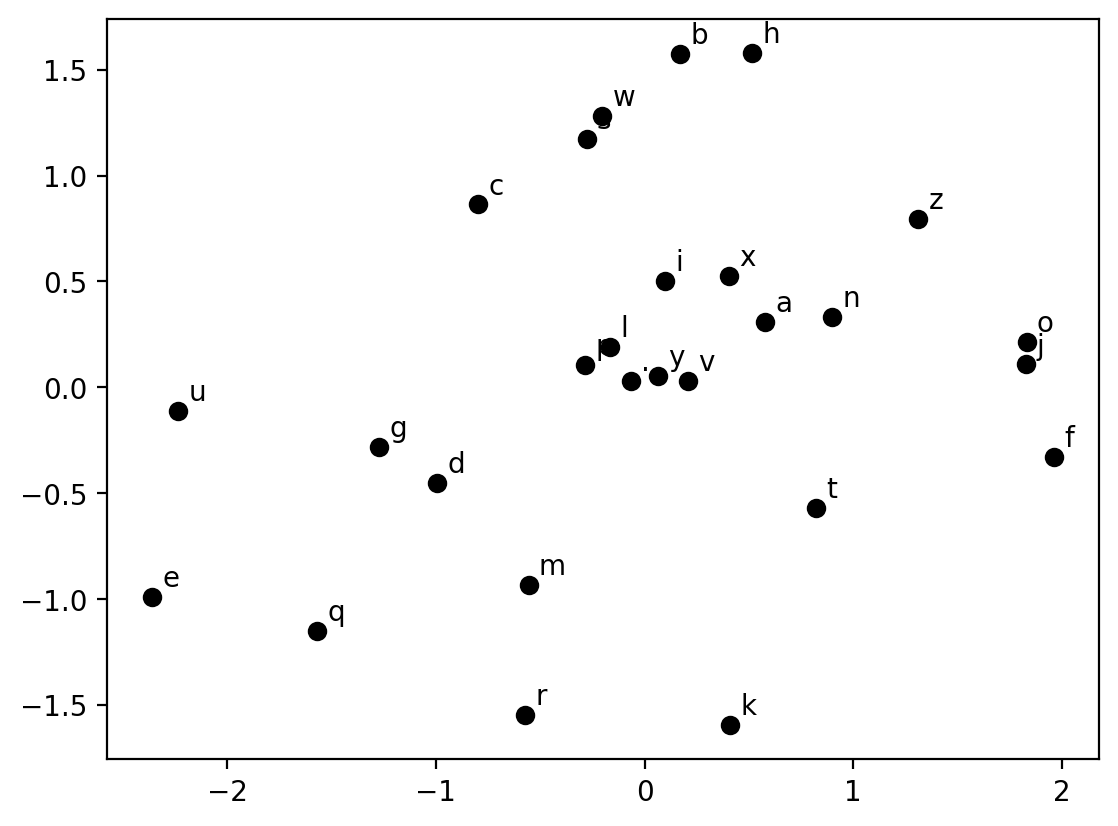

In [ ]:
# Function to visualize the embedding in 2d space

def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        x, y = emb.weight[i].detach().cpu().numpy()[:2]
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

In [ ]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x


In [ ]:
# Generate names from untrained model


model = NextChar(block_size, len(stoi), emb_dim, 10).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


mhpeclsiin
fxucwqszxl
ligbripqwn
igooixxrud
ruxedmczwk
piuhbphnuy
opcwjrvqoq
fvlioxjmyj
osvjcgdhey
apandgxxgk


# Using RNN Based method

In [ ]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []
for epoch in range(10000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())

0 2.913294553756714
100 2.184605360031128
200 2.167757511138916
300 2.1602606773376465
400 2.1566050052642822
500 2.154313325881958
600 2.1524815559387207
700 2.151942729949951
800 2.152280807495117
900 2.1523191928863525
1000 2.1523776054382324
1100 2.152209758758545
1200 2.1521425247192383
1300 2.1519908905029297
1400 2.151787042617798
1500 2.1519954204559326
1600 2.1522161960601807
1700 2.1519157886505127
1800 2.1516222953796387
1900 2.151449203491211
2000 2.151196002960205
2100 2.1507272720336914
2200 2.1503989696502686
2300 2.149923801422119
2400 2.1495912075042725
2500 2.149340867996216
2600 2.1490633487701416
2700 2.1483986377716064
2800 2.14768123626709
2900 2.1472883224487305
3000 2.147095203399658
3100 2.1469943523406982
3200 2.1469480991363525
3300 2.146942138671875
3400 2.1469497680664062
3500 2.14695143699646
3600 2.1469454765319824
3700 2.146937608718872
3800 2.1469316482543945
3900 2.146928548812866
4000 2.1469266414642334
4100 2.1469247341156006
4200 2.1469221115112305


<Axes: >

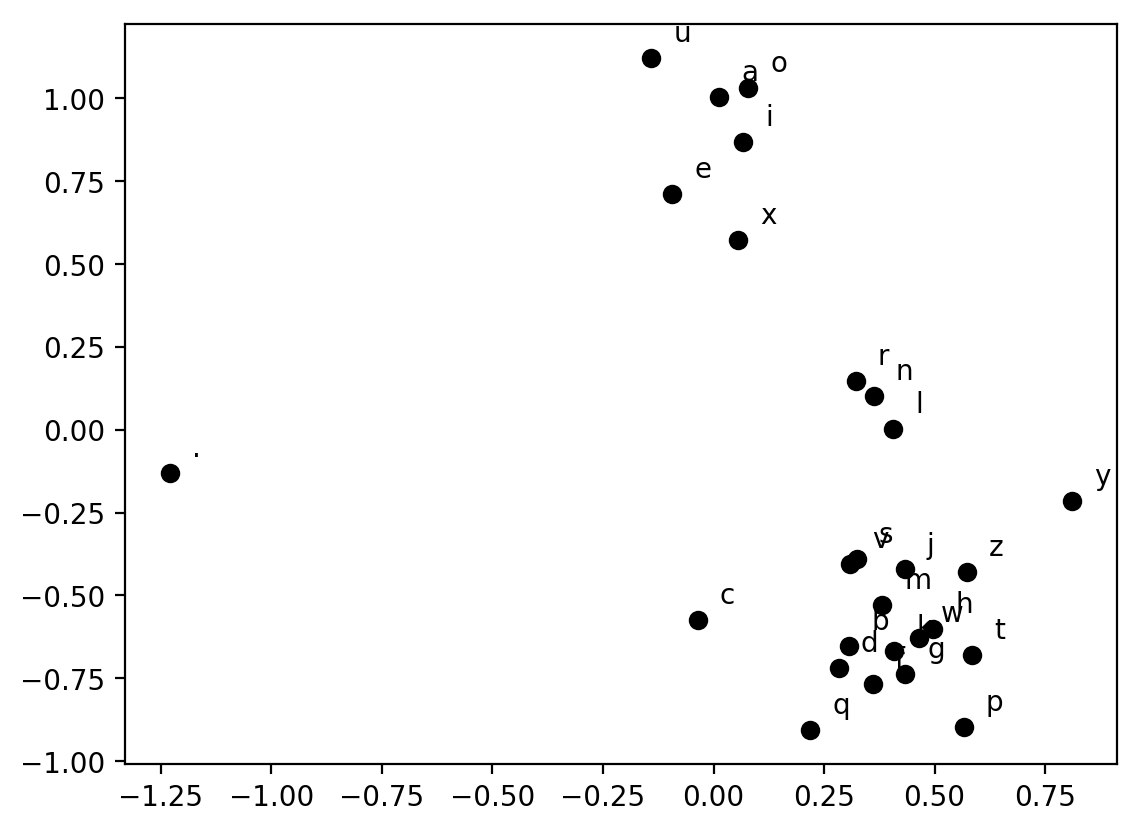

In [ ]:
# Visualize the embedding

plot_emb(model.emb, itos)

In [ ]:
# Generate names from trained model

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

susvifar
perbi
balmil
janda
titsuparam
sanu
karnatu
ipra
shral
ratru


# Fetching and Preparing data:

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-03-21 07:56:07--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-03-21 07:56:07 (22.1 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("Total number of characters in dataset are: ", len(text))

Total number of characters in dataset are:  1115394


In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

print("Unique characters in passage: ", ''.join(chars))
print("\nTotal number of unique characters:", vocab_size)

Unique characters in passage:  
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Total number of unique characters: 65


In [ ]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print("hii there: ", encode("hii there"))

print(f"\n{encode('hii there')}:", decode(encode("hii there")))

hii there:  [46, 47, 47, 1, 58, 46, 43, 56, 43]

[46, 47, 47, 1, 58, 46, 43, 56, 43]: hii there


In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype, "\n")
print(data[:100])

torch.Size([1115394]) torch.int64 

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [ ]:
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

In [ ]:
print("Length of training data:", len(train_data))
train_data, val_data

Length of training data: 892315


(tensor([18, 47, 56,  ..., 39, 58,  1]),
 tensor([63, 53, 59,  ..., 45,  8,  0]))

#### for explaination only....

In [ ]:
block_size = 4
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"Input: {context}; Output: {target}")

Input: tensor([18]); Output: 47
Input: tensor([18, 47]); Output: 56
Input: tensor([18, 47, 56]); Output: 57
Input: tensor([18, 47, 56, 57]); Output: 58


In [ ]:
torch.manual_seed(1294)
import pprint
batch_size = 4 # independent sequences processed in parallel
block_size = 10 # maximum context length for predictions

def get_batch(split):
    if split == 'train':
      data = train_data
    else:
      data = val_data
    #print(len(data))
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

input, target = get_batch('train')
print('Input:')
print(input.shape)
print(input)

print('\nOutput:')
print(target.shape)
print(target)

Input:
torch.Size([4, 10])
tensor([[ 1, 40, 50, 53, 58, 12,  0,  0, 13, 40],
        [60, 43,  1, 53, 52, 43,  0, 27, 44,  1],
        [56, 39, 52, 58,  6,  1, 44, 53, 56,  1],
        [43, 43,  6,  1, 53, 50, 42,  1, 15, 39]])

Output:
torch.Size([4, 10])
tensor([[40, 50, 53, 58, 12,  0,  0, 13, 40, 40],
        [43,  1, 53, 52, 43,  0, 27, 44,  1, 57],
        [39, 52, 58,  6,  1, 44, 53, 56,  1, 58],
        [43,  6,  1, 53, 50, 42,  1, 15, 39, 54]])


In [ ]:
len(input)

4

In [ ]:
for b in range(batch_size): # batch dimension
    print("")
    for t in range(block_size): # time dimension
        context = input[b, :t+1]
        target_ = target[b,t]
        print(f"when input is {context.tolist()} the target: {target_}")


when input is [1] the target: 40
when input is [1, 40] the target: 50
when input is [1, 40, 50] the target: 53
when input is [1, 40, 50, 53] the target: 58
when input is [1, 40, 50, 53, 58] the target: 12
when input is [1, 40, 50, 53, 58, 12] the target: 0
when input is [1, 40, 50, 53, 58, 12, 0] the target: 0
when input is [1, 40, 50, 53, 58, 12, 0, 0] the target: 13
when input is [1, 40, 50, 53, 58, 12, 0, 0, 13] the target: 40
when input is [1, 40, 50, 53, 58, 12, 0, 0, 13, 40] the target: 40

when input is [60] the target: 43
when input is [60, 43] the target: 1
when input is [60, 43, 1] the target: 53
when input is [60, 43, 1, 53] the target: 52
when input is [60, 43, 1, 53, 52] the target: 43
when input is [60, 43, 1, 53, 52, 43] the target: 0
when input is [60, 43, 1, 53, 52, 43, 0] the target: 27
when input is [60, 43, 1, 53, 52, 43, 0, 27] the target: 44
when input is [60, 43, 1, 53, 52, 43, 0, 27, 44] the target: 1
when input is [60, 43, 1, 53, 52, 43, 0, 27, 44, 1] the targ

# Simple Bigram Model using Neural Network

In [ ]:
class NeuralNetworkModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = NeuralNetworkModel(vocab_size)
logits, loss = m(input, target)
print(logits.shape)
#print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([40, 65])

KDhRL..lafzHYz
l:U fpVFEbBoCAsGuMOOJJkwo
TB,ydpFLriKSPwwihh-P,JEiffpIJQlt.SSlwvmWEkvUuIIOfgzEbPtG;uh


In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
batch_size = 32
for steps in range(100): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    print(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

4.694812774658203
4.725152015686035
4.735060214996338
4.723618507385254
4.737090587615967
4.750146865844727
4.725000381469727
4.70699405670166
4.678304672241211
4.718472480773926
4.696362495422363
4.666830062866211
4.628401756286621
4.666481971740723
4.659774303436279
4.619102478027344
4.67460298538208
4.698578834533691
4.670655250549316
4.679381847381592
4.61317253112793
4.733055114746094
4.6373291015625
4.661691188812256
4.711420059204102
4.703858375549316
4.714614391326904
4.633647918701172
4.65870475769043
4.686230659484863
4.68086576461792
4.694855690002441
4.649325847625732
4.748202323913574
4.746114730834961
4.560848236083984
4.664766311645508
4.544810771942139
4.726621150970459
4.588901042938232
4.668590068817139
4.700176239013672
4.722327709197998
4.641680717468262
4.700586795806885
4.691437721252441
4.7698211669921875
4.7672319412231445
4.649369239807129
4.583395957946777
4.664675712585449
4.667143821716309
4.638619899749756
4.585790157318115
4.628730297088623
4.6365852355957

In [ ]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


'YsKKnIWNIOyOsNLutw.QaiKPpj;LDd;;uzuEzt,XgLoAfqQSd!pLXFE$wv?PwT.A$I,I,A$$&KVmC3LNnCsNCanE?WT?S
K?wJk?;Et H UbSrAOs&JSrMJ$uiiRqxe:
K:hHn,WTWQe nsIb'CtVP&www'KRmG r&E.NqQq;h3UEkGlG$&.seXh3II fCd
'WSUcPRqCWL.YSsZFirA .SdinxM3JFvzYK,S?Z
hrbJiO; riihHFAsicOOCRfT3Lx$wozkcfhteyqm;ijZwZD dTos:SPLezjZmpCHn!cihJF'WbB
TNqMquUKtWhg.SD,WuUL.oysldpqx.;
YzaZRbx;tfpn yY nJnvt.LaD.&zn$jZBd;VwYqj;bf&K3G 'o,H'W&zgaVS&:D-k?oYdA3BuIuEku-yu-&!kUdk'CDa&.DHLxlH!OPJGvcQWKj$XsiDhrfH-Iqih;lG$nBxnrDO-JX-x-QaH
H3cToh$&bylwJ


That, poor contempt, or claim'd thou slept so faithful,
I may contrive our father; and, in their def


In [ ]:
import nltk
nltk.download('punkt')
sentences = nltk.sent_tokenize(text_content)
sentences[:100]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


["That, poor contempt, or claim'd thou slept so faithful,\nI may contrive our father; and, in their defeated queen,\nHer flesh broke me and puttance of expedition house,\nAnd in that same that ever I lament this stomach,\nAnd he, nor Butly and my fury, knowing everything\nGrew daily ever, his great strength and thought\nThe bright buds of mine own.",
 "BIONDELLO:\nMarry, that it may not pray their patience.'",
 'KING LEAR:\nThe instant common maid, as we may less be\na brave gentleman and joiner: he that finds us with wax\nAnd owe so full of presence and our fooder at our\nstaves.',
 "It is remorsed the bridal's man his grace\nfor every business in my tongue, but I was thinking\nthat he contends, he hath respected thee.",
 "BIRON:\nShe left thee on, I'll die to blessed and most reasonable\nNature in this honour, and her bosom is safe, some\nothers from his speedy-birth, a bill and as\nForestem with Richard in your heart\nBe question'd on, nor that I was enough:\nWhich of a partier fort